In [111]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

import pickle

# 1.Load Data

In [2]:
data = np.load("../my_comp_train_XY.npz")
X = data["X"]
y = data["y"]

# 2.Split train, valid and test data

In [6]:
X = X.reshape(-1, 28, 28, 1)
# split train, valid and test data(ratio 0.6:0.2:0.2)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=10)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=10)

In [7]:
# X_data 0 to 1 scaled
X_train_scaled = X_train / 255.0
X_valid_scaled = X_valid / 255.0
X_test_scaled = X_test / 255.0

In [8]:
print("Train data shape, X_train.shape:{} y_train.shape:{}".format(X_train_scaled.shape, y_train.shape))
print("Valid data shape, X_valid.shape:{} y_valid.shape:{}".format(X_valid_scaled.shape, y_valid.shape))
print("Test data shape, X_test.shape:{} y_test.shape:{}".format(X_test_scaled.shape, y_test.shape))

Train data shape, X_train.shape:(27285, 28, 28, 1) y_train.shape:(27285,)
Valid data shape, X_valid.shape:(9096, 28, 28, 1) y_valid.shape:(9096,)
Test data shape, X_test.shape:(9096, 28, 28, 1) y_test.shape:(9096,)


# 3.Classification

## 3-1.CNN base model

### 3-1-1.Training model

In [43]:
def ram_with_CNN_training(input_shape, cnn_layers_shape, batch_size, param_number, pc_byte=8):
    """Calcurate ow much memory(byte) CNN need"""
    input_data_ch_number = input_shape[2]
    input_data_memory = batch_size * input_shape[0] * input_shape[1] * input_data_ch_number * pc_byte
    param_memory = param_number * pc_byte
    cnn_feature_map_memory = 0
    for cnn_layer_shape in cnn_layers_shape:
        cnn_feature_map_volume = cnn_layer_shape[0] * cnn_layer_shape[1] * cnn_layer_shape[2]
        cnn_feature_map_memory += batch_size * cnn_feature_map_volume * pc_byte
        
    ram_memory = input_data_memory + param_memory + cnn_feature_map_memory
    print("RAM memory:{} GByte".format(ram_memory / 1000000000))

In [9]:
keras.backend.clear_session()

In [17]:
# input layer number of neuron
INPUT_SHAPE = (28, 28, 1)
# output layer number of neuron
OUTPUT_SIZE = 10
# output layer activation function
OUTPUT_LAYER_ACTIVATION_FUNC = "softmax"
# loss function
LOSS_FUNC = "sparse_categorical_crossentropy"

In [11]:
# Fix epochs and batch size
epochs = 30
batch_size = 32

In [12]:
# validation data
validation_data = (X_valid_scaled, y_valid)

In [18]:
# base model
cnn_clf_base = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation="relu", padding="same", input_shape=INPUT_SHAPE),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(OUTPUT_SIZE, activation=OUTPUT_LAYER_ACTIVATION_FUNC),
])

In [19]:
cnn_clf_base.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 64)        3200      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In [44]:
# calculate how much RAM memory CNN model need
param_number = 626762
cnn_layers_shape = [[28, 28, 64], [14, 14, 128], [14, 14, 128]]

ram_with_CNN_training(input_shape=INPUT_SHAPE, cnn_layers_shape=cnn_layers_shape, 
                                   batch_size=batch_size, param_number=param_number, pc_byte=8)

RAM memory:0.030904912 GByte


### memo

my PC RAM is 8.0GB, so in this model enough memory

In [48]:
cnn_clf_base.compile(loss=LOSS_FUNC, metrics=["accuracy"], optimizer="Adam")

In [45]:
# early stopping callback
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [49]:
# train model and accuracy evaluation with validation data
history = cnn_clf_base.fit(X_train_scaled, y_train, epochs=epochs,
                         batch_size=batch_size,
                         validation_data=validation_data,
                         callbacks=[early_stopping_cb])

Epoch 1/30
853/853 [==============================] - 145s 169ms/step - loss: 0.1821 - accuracy: 0.9415 - val_loss: 0.0706 - val_accuracy: 0.9805
Epoch 2/30
853/853 [==============================] - 141s 165ms/step - loss: 0.0544 - accuracy: 0.9837 - val_loss: 0.0762 - val_accuracy: 0.9756
Epoch 3/30
853/853 [==============================] - 140s 164ms/step - loss: 0.0374 - accuracy: 0.9882 - val_loss: 0.0504 - val_accuracy: 0.9845
Epoch 4/30
853/853 [==============================] - 167s 195ms/step - loss: 0.0299 - accuracy: 0.9908 - val_loss: 0.0479 - val_accuracy: 0.9849
Epoch 5/30
853/853 [==============================] - 145s 170ms/step - loss: 0.0244 - accuracy: 0.9924 - val_loss: 0.0483 - val_accuracy: 0.9859
Epoch 6/30
853/853 [==============================] - 173s 203ms/step - loss: 0.0185 - accuracy: 0.9936 - val_loss: 0.0404 - val_accuracy: 0.9880
Epoch 7/30
853/853 [==============================] - 156s 183ms/step - loss: 0.0153 - accuracy: 0.9952 - val_loss: 0.0451 -

In [50]:
train_loss, valid_loss = history.history["loss"], history.history["val_loss"]
train_acc, valid_acc = history.history["accuracy"], history.history["val_accuracy"]

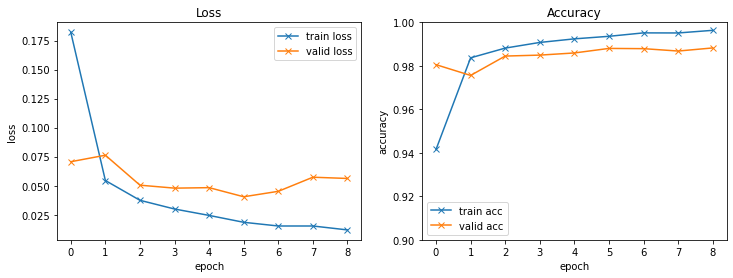

In [51]:
# plot loss and accuracy score with train and valid data along epoch

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(range(len(train_loss)), train_loss, "-x", label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, "-x", label="valid loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.title("Loss")

plt.subplot(122)
plt.plot(range(len(train_acc)), train_acc, "-x", label="train acc")
plt.plot(range(len(valid_acc)), valid_acc, "-x", label="valid acc")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.ylim([0.9, 1.0])
plt.legend()
plt.title("Accuracy")

plt.show()

### 3-1-2.Evaluate model

In [53]:
# evaluate accuracy score with test data
test_score_base = cnn_clf_base.evaluate(X_test_scaled, y_test)
print("Test loss:{}, Test accuracy:{}".format(test_score_base[0], test_score_base[1]))

285/285 [==============================] - 18s 63ms/step - loss: 0.0477 - accuracy: 0.9868
Test loss:0.047667764127254486, Test accuracy:0.9868074059486389


In [60]:
# predict with train, valid and test data
y_pred_train = np.argmax(cnn_clf_base.predict(X_train_scaled), axis=-1)
y_pred_valid = np.argmax(cnn_clf_base.predict(X_valid_scaled), axis=-1)
y_pred_test = np.argmax(cnn_clf_base.predict(X_test_scaled), axis=-1)

In [64]:
# Accuracy score
print("Train accuracy score: \t{}".format(accuracy_score(y_train, y_pred_train)))
print("Valid accuracy score: \t{}".format(accuracy_score(y_valid, y_pred_valid)))
print("Test accuracy score: \t{}".format(accuracy_score(y_test, y_pred_test)))

Train accuracy score: 	0.9965915338097856
Valid accuracy score: 	0.9880167106420404
Test accuracy score: 	0.9868073878627969


In [62]:
# confusion matrix
matric_cnn_clf_base_train = confusion_matrix(y_true=y_train, y_pred=y_pred_train)
matric_cnn_clf_base_valid = confusion_matrix(y_true=y_valid, y_pred=y_pred_valid)
matric_cnn_clf_base_test = confusion_matrix(y_true=y_test, y_pred=y_pred_test)

Text(0.5, 1.0, 'Test data')

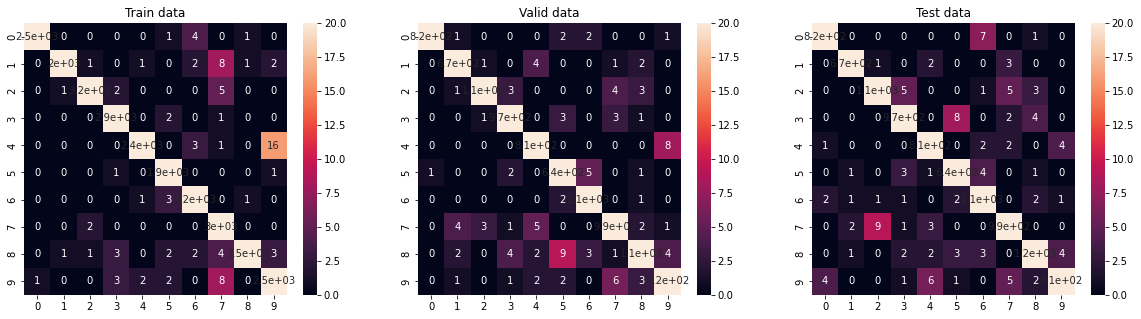

In [63]:
# confusion matrix plot
fig, axes = plt.subplots(1, 3, figsize=(20,5))
sns.heatmap(matric_cnn_clf_base_train, annot=True, vmin=0, vmax=20, ax=axes[0])
axes[0].set_title("Train data")
sns.heatmap(matric_cnn_clf_base_valid, annot=True, vmin=0, vmax=20, ax=axes[1])
axes[1].set_title("Valid data")
sns.heatmap(matric_cnn_clf_base_test, annot=True, vmin=0, vmax=20, ax=axes[2])
axes[2].set_title("Test data")

In [148]:
# save the base model
cnn_clf_base.save("C:/Users/FYOSHIAKI/Documents/ml_compe/cnn_clf_base_model.h5")

### 3-1-3.observe wrong prediction of valid data

In [67]:
wrong_predict_mask = (y_valid != y_pred_valid)

In [81]:
wrong_predict_indicies = np.where(wrong_predict_mask == True)[0]

In [83]:
len(wrong_predict_indicies)

109

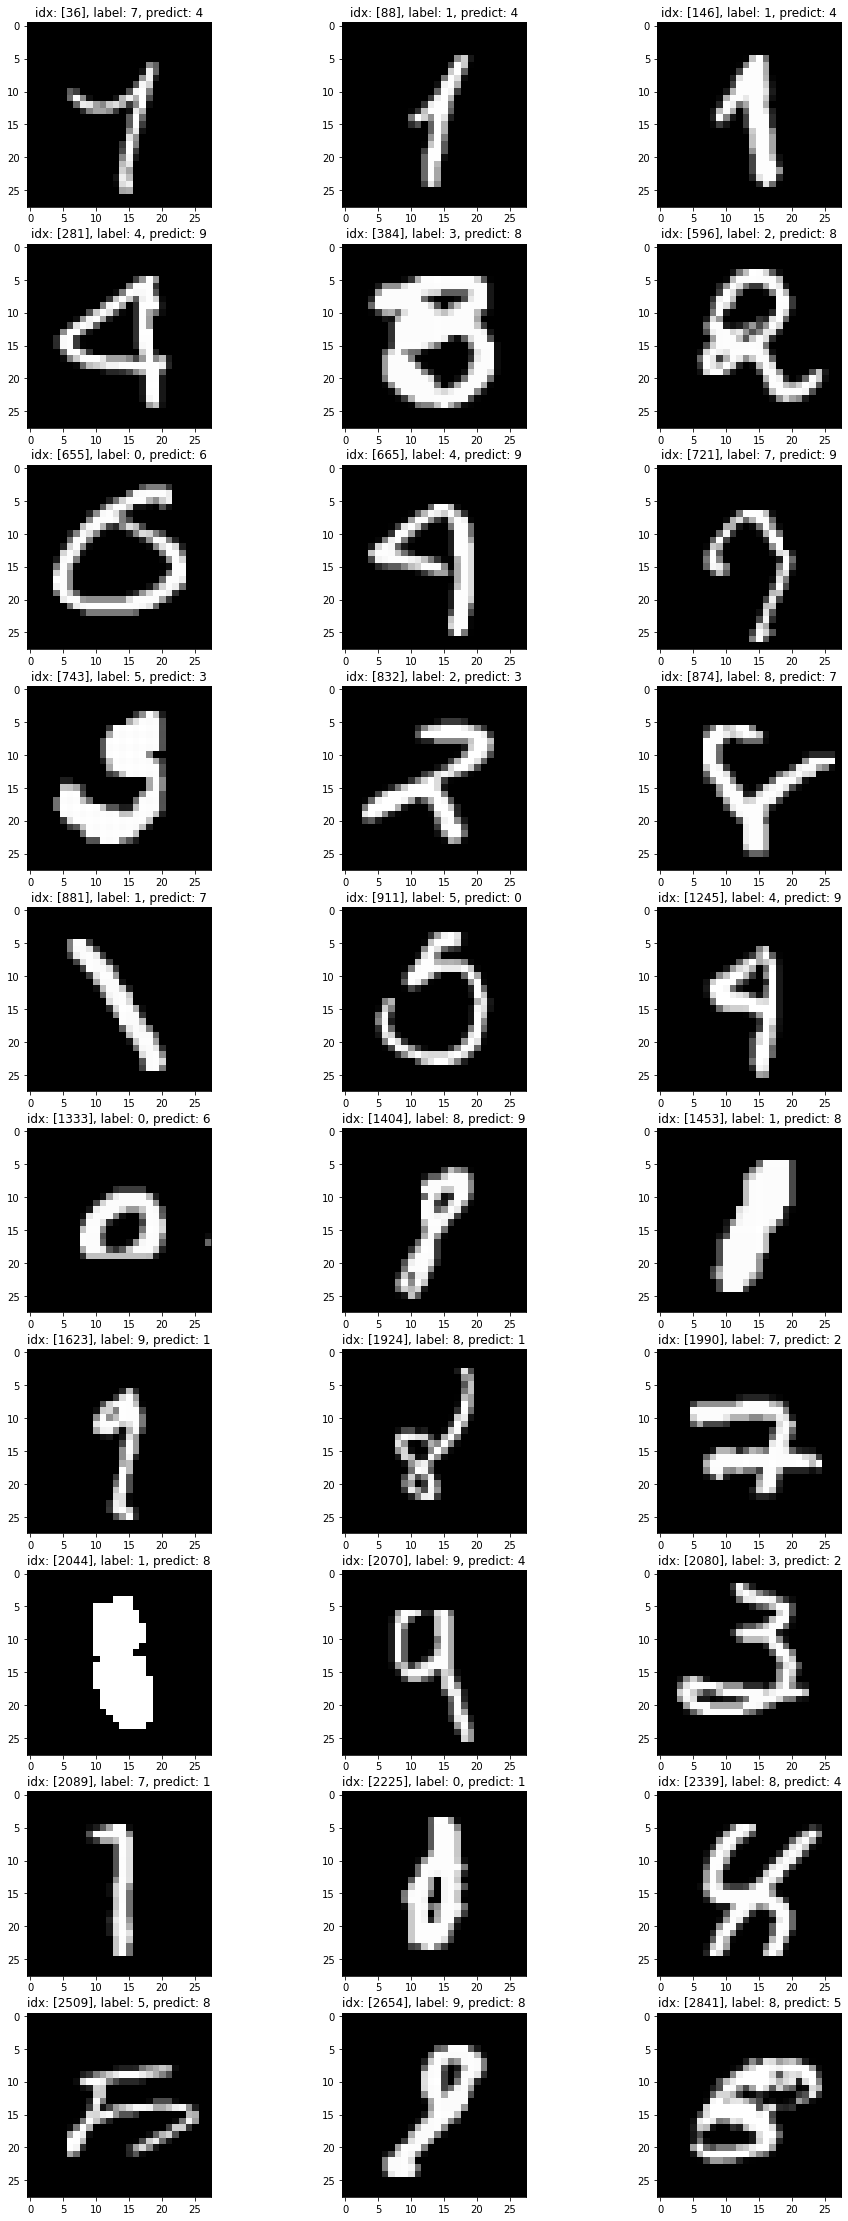

In [97]:
plt.subplots(10, 3, figsize=(16, 40))
plt.subplot(10,3,1)

for count, wrong_idx in enumerate(wrong_predict_indicies):
    if count >= 30:
        break
    plt.subplot(10, 3, count + 1)
    plt.imshow(X_valid_scaled[wrong_idx].reshape(28, 28), cmap="gray")
    plt.title("idx: [{}], label: {}, predict: {}".format(wrong_idx, y_valid[wrong_idx], y_pred_valid[wrong_idx]))

### observation

index = 88, 146, 281, 655, 881, 1333, 1453 is predictable...? so hyper parameter tuning maybe cause better prediction

## 3-2.CNN hyper parameter tuning

### tuning hyper param is below

・cnn filter number/cnn filter shape

In [99]:
# Hyper params: hidden layers
cnn_filters_number = [[32, 64], [64, 128], [128, 256]]
cnn_filters_shape = [[5, 3], [7, 3], [7, 5], [7, 7]]

In [106]:
# input layer number of neuron
INPUT_SHAPE = (28, 28, 1)
# output layer number of neuron
OUTPUT_SIZE = 10
# output layer activation function
OUTPUT_LAYER_ACTIVATION_FUNC = "softmax"
# loss function
LOSS_FUNC = "sparse_categorical_crossentropy"

# Fix epochs and batch size
epochs = 30
batch_size = 32

# validation data
validation_data = (X_valid_scaled, y_valid)

# early stopping callback
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [105]:
def build_model_tune_hyper_param(cnn_filter_number, cnn_filter_shape):
    """ Build model with tuning hyper param(cnn_filter_number, cnn_filter_shape)"""
    keras.backend.clear_session()
    model = keras.models.Sequential([
    keras.layers.Conv2D(cnn_filter_number[0], cnn_filter_shape[0], activation="relu",
                        padding="same", input_shape=INPUT_SHAPE),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(cnn_filter_number[1], cnn_filter_shape[1], activation="relu", padding="same"),
    keras.layers.Conv2D(cnn_filter_number[1], cnn_filter_shape[1], activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(OUTPUT_SIZE, activation=OUTPUT_LAYER_ACTIVATION_FUNC),
])
    
    model.compile(loss=LOSS_FUNC, metrics=["accuracy"], optimizer="Adam")
    return model

In [108]:
result_tune_cnn_filters = []

# train model with changing cnn_filters
for cnn_filter_number in cnn_filters_number:
    for cnn_filter_shape in cnn_filters_shape:
        model = build_model_tune_hyper_param(cnn_filter_number, cnn_filter_shape)

        history = model.fit(X_train_scaled, y_train, epochs=epochs,
                         batch_size=batch_size,
                         validation_data=validation_data,
                         callbacks=[early_stopping_cb])
            
        train_loss, val_loss = history.history["loss"], history.history["val_loss"]
        model_summery = {
            "cnn_filter_number": cnn_filter_number,
            "cnn_filter_shape": cnn_filter_shape,
            "history": history,
            "model": model,
            "train_loss": train_loss,
            "val_loss": val_loss,
        }
        result_tune_cnn_filters.append(model_summery)

Epoch 1/30
853/853 [==============================] - 71s 83ms/step - loss: 0.1947 - accuracy: 0.9393 - val_loss: 0.0758 - val_accuracy: 0.9769
Epoch 2/30
853/853 [==============================] - 68s 79ms/step - loss: 0.0549 - accuracy: 0.9834 - val_loss: 0.0669 - val_accuracy: 0.9782
Epoch 3/30
853/853 [==============================] - 69s 80ms/step - loss: 0.0407 - accuracy: 0.9872 - val_loss: 0.0663 - val_accuracy: 0.9772
Epoch 4/30
853/853 [==============================] - 68s 80ms/step - loss: 0.0269 - accuracy: 0.9913 - val_loss: 0.0465 - val_accuracy: 0.9858
Epoch 5/30
853/853 [==============================] - 69s 81ms/step - loss: 0.0237 - accuracy: 0.9919 - val_loss: 0.0403 - val_accuracy: 0.9871
Epoch 6/30
853/853 [==============================] - 69s 81ms/step - loss: 0.0172 - accuracy: 0.9944 - val_loss: 0.0463 - val_accuracy: 0.9865
Epoch 7/30
853/853 [==============================] - 71s 83ms/step - loss: 0.0149 - accuracy: 0.9948 - val_loss: 0.0489 - val_accuracy:

853/853 [==============================] - 363s 426ms/step - loss: 0.0175 - accuracy: 0.9948 - val_loss: 0.0337 - val_accuracy: 0.9904
Epoch 7/30
853/853 [==============================] - 360s 423ms/step - loss: 0.0169 - accuracy: 0.9946 - val_loss: 0.0610 - val_accuracy: 0.9833
Epoch 8/30
853/853 [==============================] - 358s 419ms/step - loss: 0.0151 - accuracy: 0.9956 - val_loss: 0.0712 - val_accuracy: 0.9845
Epoch 9/30
853/853 [==============================] - 358s 419ms/step - loss: 0.0129 - accuracy: 0.9963 - val_loss: 0.0444 - val_accuracy: 0.9888
Epoch 1/30
853/853 [==============================] - 719s 843ms/step - loss: 0.1809 - accuracy: 0.9429 - val_loss: 0.0796 - val_accuracy: 0.9752
Epoch 2/30
853/853 [==============================] - 758s 889ms/step - loss: 0.0537 - accuracy: 0.9836 - val_loss: 0.0647 - val_accuracy: 0.9809
Epoch 3/30
853/853 [==============================] - 742s 870ms/step - loss: 0.0364 - accuracy: 0.9889 - val_loss: 0.0455 - val_accura

In [130]:
def plot_loss(results, ylim_min=None, ylim_max=None):
    plt.figure(figsize=(20, 40))
    for row, result in enumerate(results):
        plt.subplot(3, 2, 1 + 2 * (row // 4))
        plt.plot(range(len(result["train_loss"])), result["train_loss"], "-x", label=result["cnn_filter_shape"])
        if row % 4 == 0: 
            plt.ylabel("train loss")
            plt.xlabel("epoch")
            plt.ylim([ylim_min, ylim_max])
            plt.title("Train Loss (cnn_filter_number: {})"
                         .format(result["cnn_filter_number"]))
        plt.legend()

        plt.subplot(3, 2, 2 + 2 * (row // 4))
        plt.plot(range(len(result["val_loss"])), result["val_loss"], "-x", label=result["cnn_filter_shape"])
        if row % 4 == 0: 
            plt.ylabel("train loss")
            plt.xlabel("epoch")
            plt.ylim([ylim_min, ylim_max])
            plt.legend()
            plt.title("Train Loss (cnn_filter_number: {})"
                         .format(result["cnn_filter_number"]))
        plt.legend()

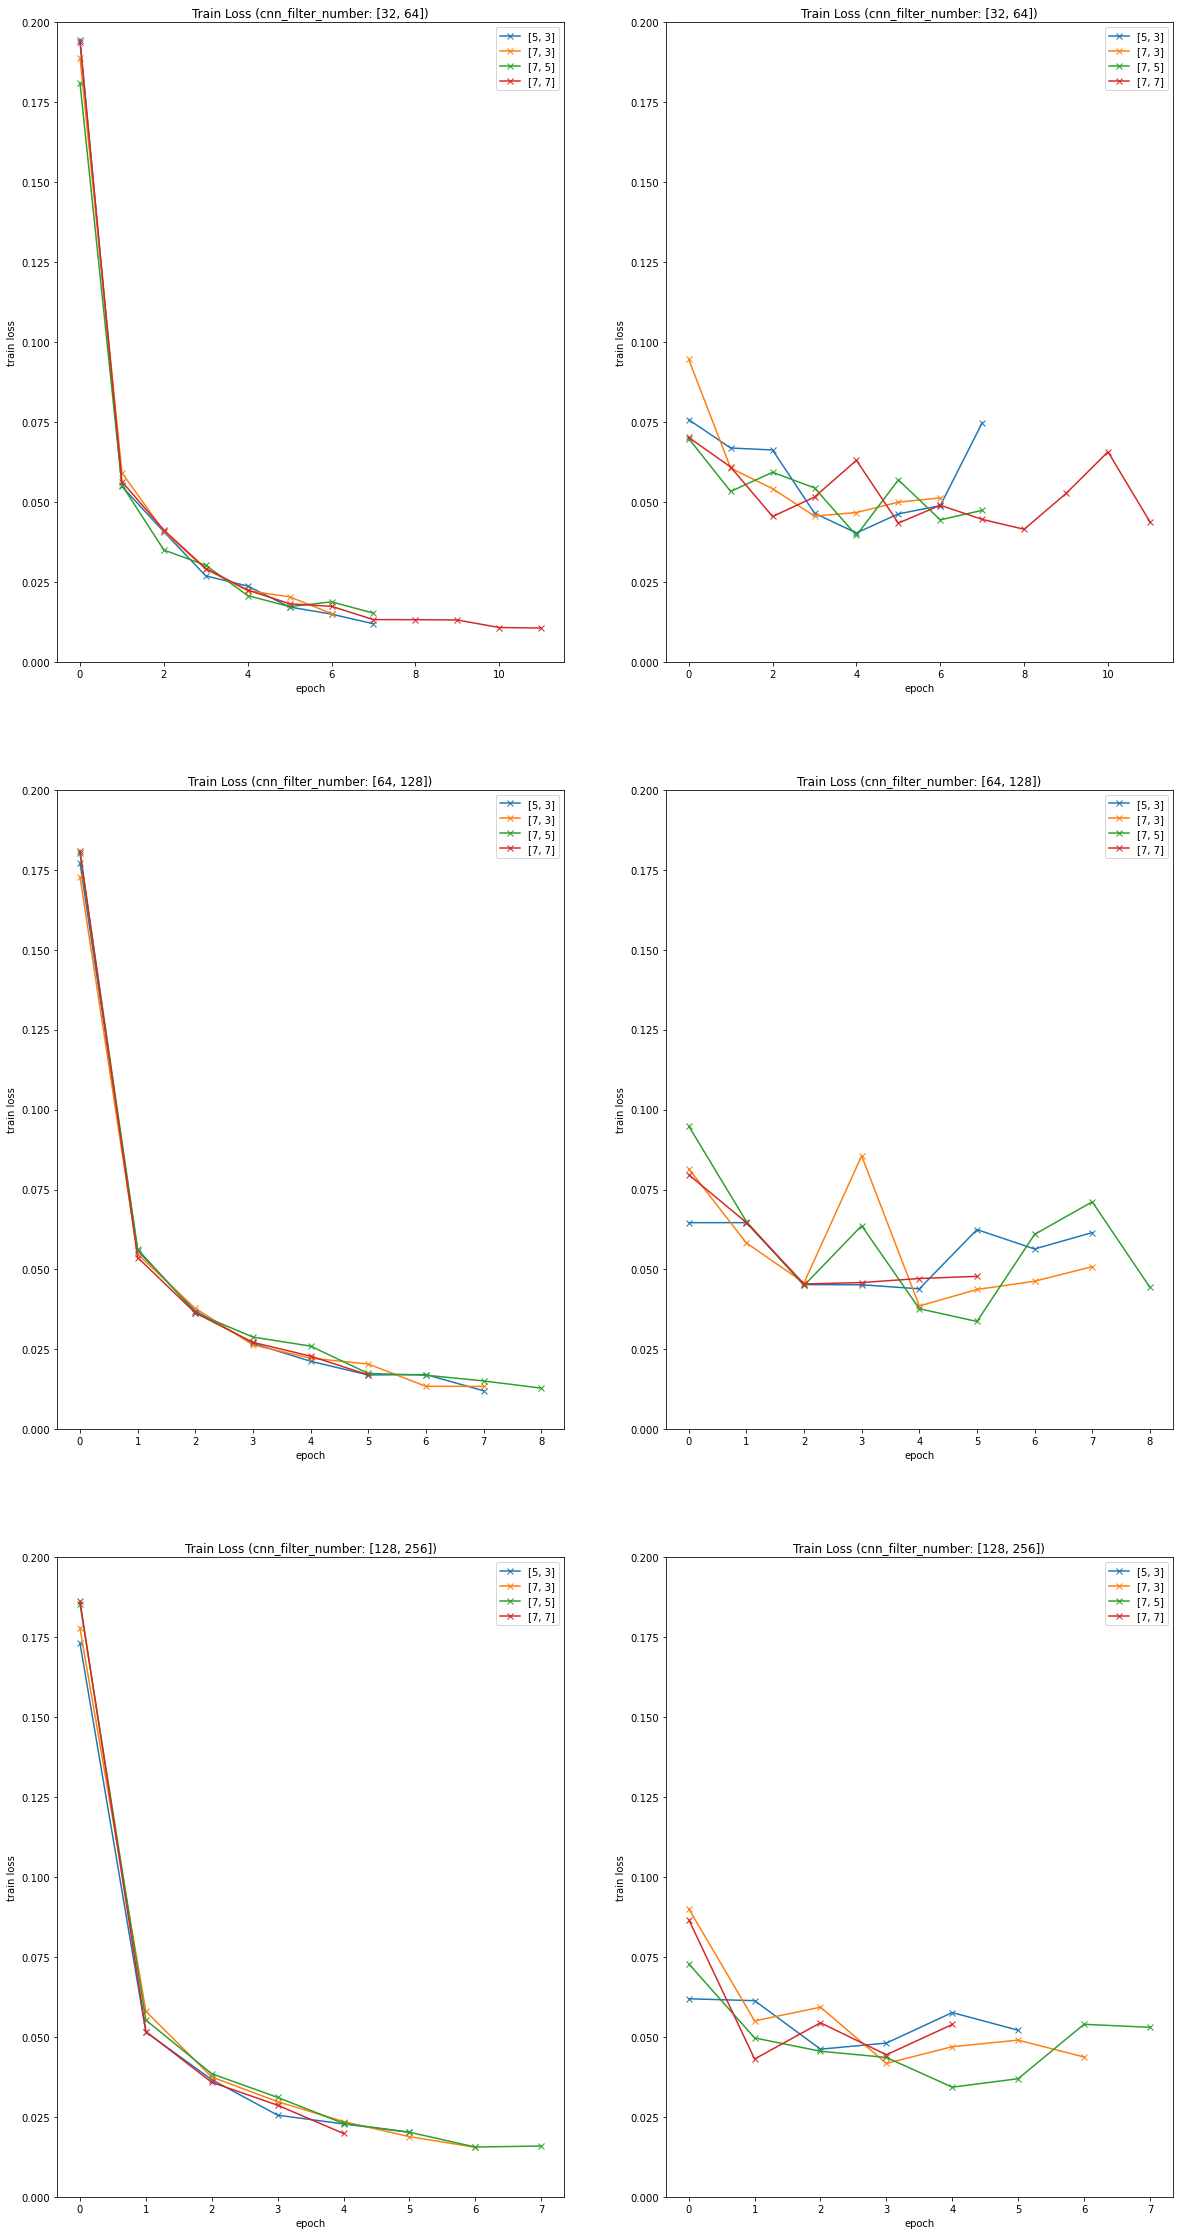

In [131]:
plot_loss(results=result_tune_cnn_filters, ylim_min=0.0, ylim_max=0.2)

In [134]:
def plot_acc(results, ylim_min=None, ylim_max=None):
    plt.figure(figsize=(20, 40))
    for row, result in enumerate(results):
        plt.subplot(3, 2, 1 + 2 * (row // 4))
        plt.plot(range(len(result["history"].history["accuracy"])), result["history"].history["accuracy"], "-x", label=result["cnn_filter_shape"])
        if row % 4 == 0: 
            plt.ylabel("train accuracy")
            plt.xlabel("epoch")
            plt.ylim([ylim_min, ylim_max])
            plt.title("Train accuracy (cnn_filter_number: {})"
                         .format(result["cnn_filter_number"]))
        plt.legend()

        plt.subplot(3, 2, 2 + 2 * (row // 4))
        plt.plot(range(len(result["history"].history["val_accuracy"])), result["history"].history["val_accuracy"], "-x", label=result["cnn_filter_shape"])
        if row % 4 == 0: 
            plt.ylabel("train accuracy")
            plt.xlabel("epoch")
            plt.ylim([ylim_min, ylim_max])
            plt.legend()
            plt.title("Train accuracy (cnn_filter_number: {})"
                         .format(result["cnn_filter_number"]))
        plt.legend()

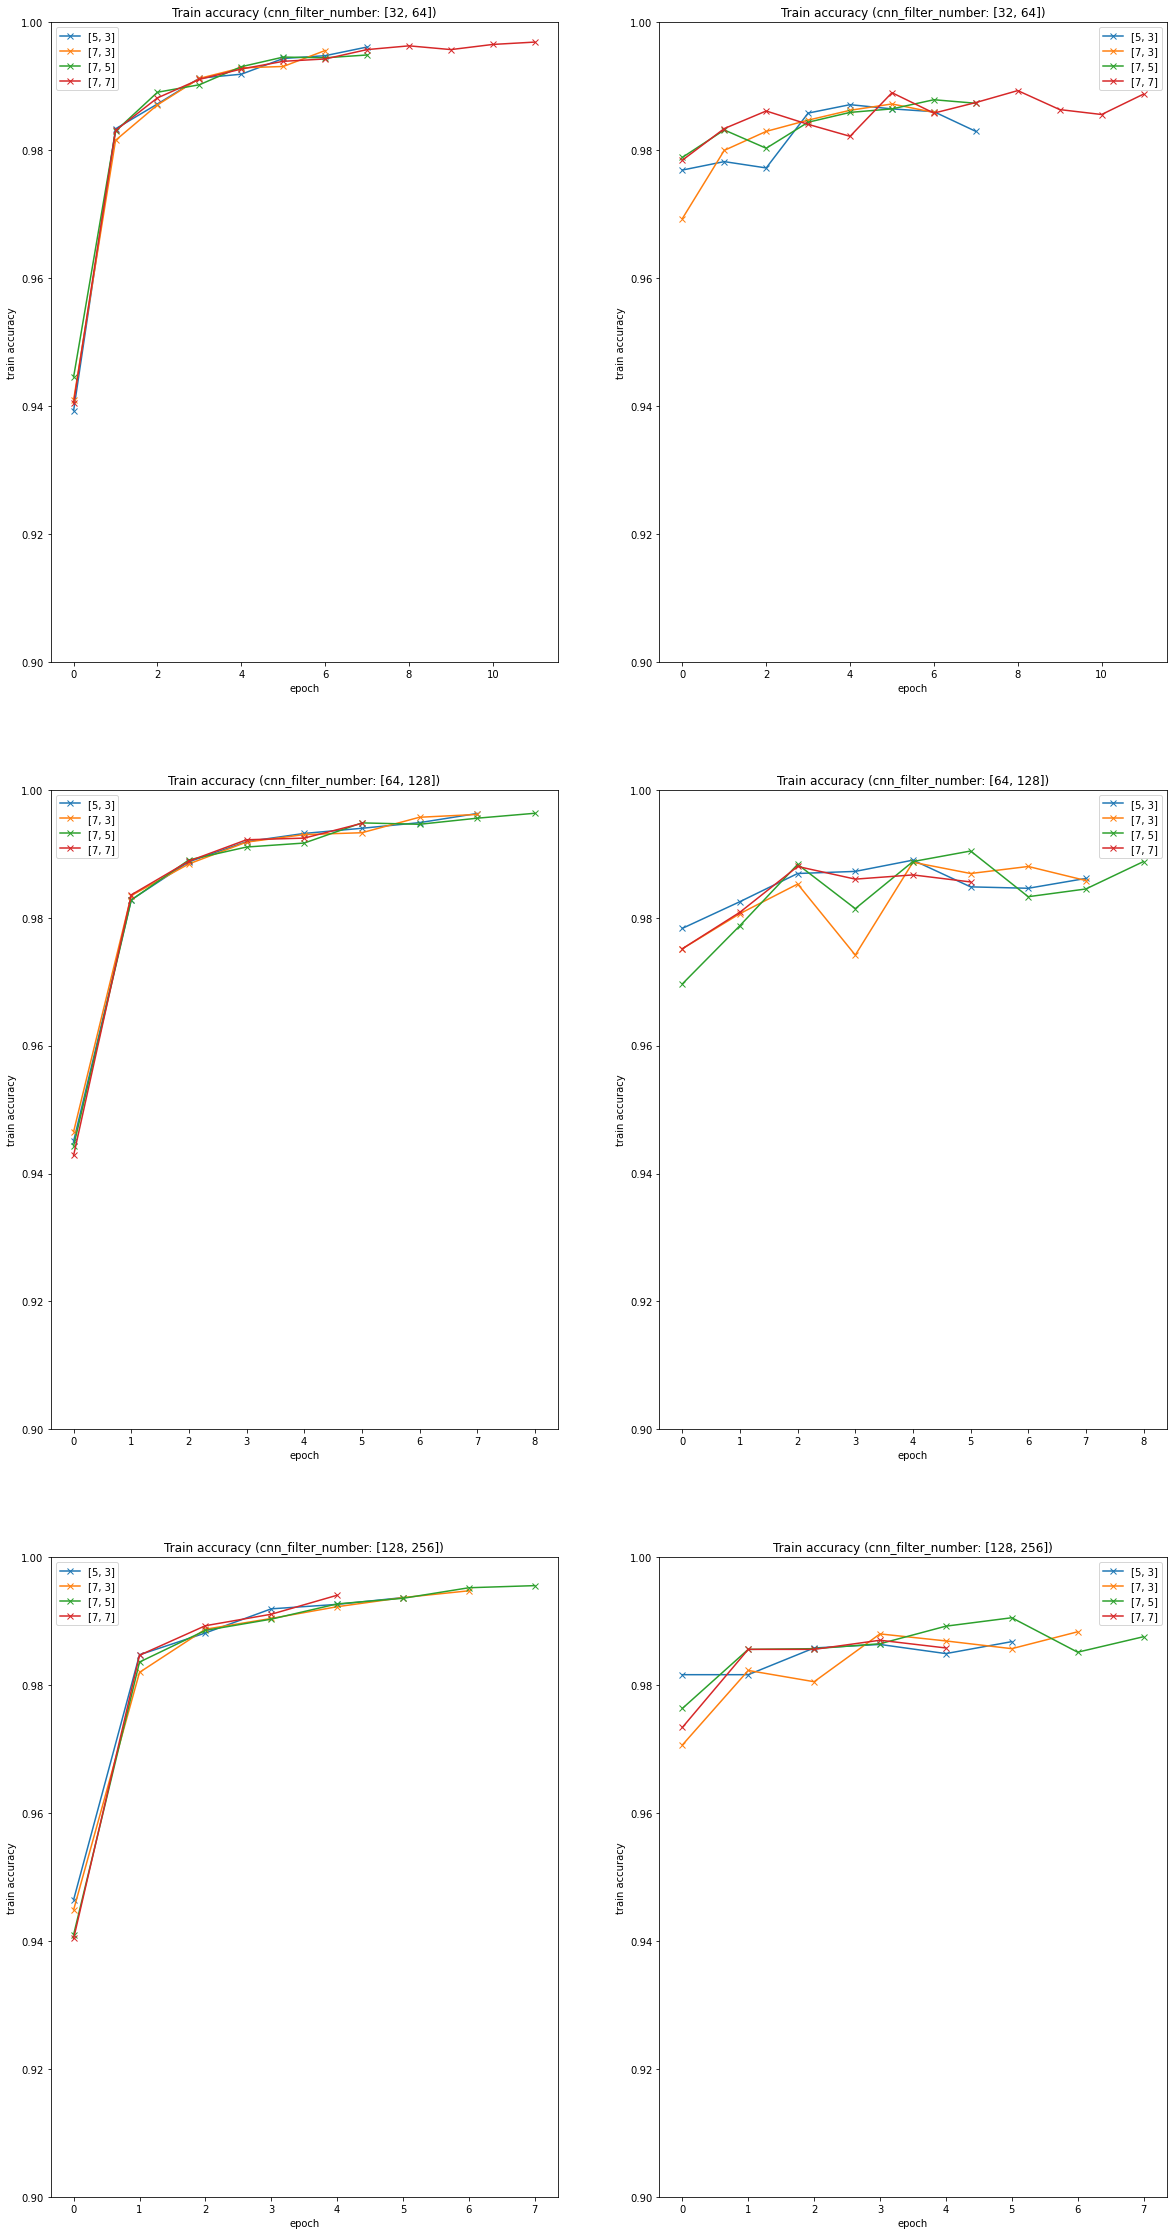

In [135]:
plot_acc(results=result_tune_cnn_filters, ylim_min=0.9, ylim_max=1.0)

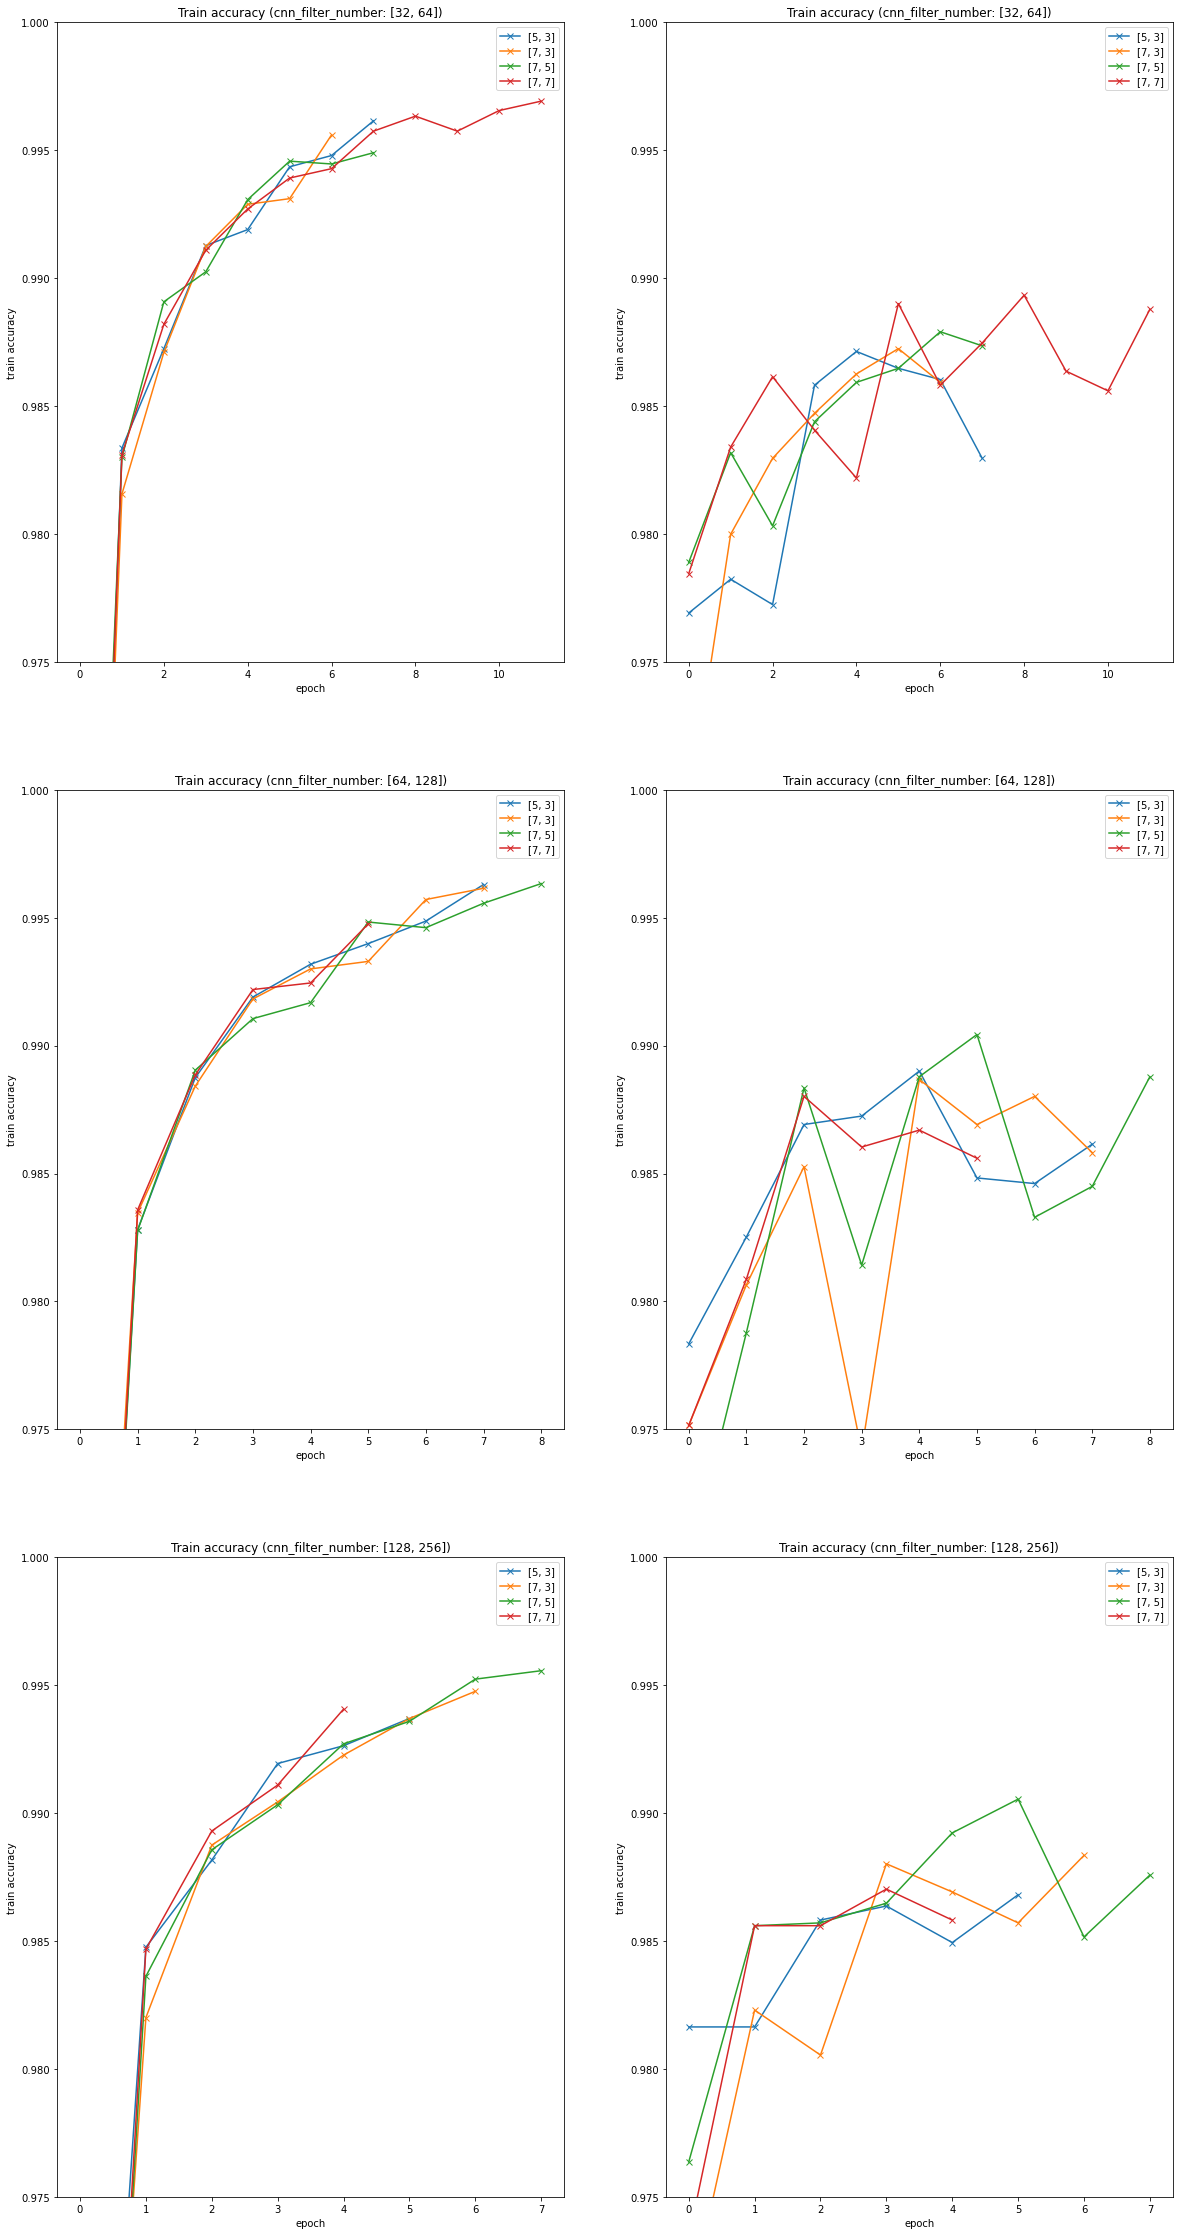

In [136]:
plot_acc(results=result_tune_cnn_filters, ylim_min=0.975, ylim_max=1.0)

#### observation

・best cnn_filter_number = [128, 256]

・best_cnn_filter_shape = [7, 5]

## 3-2-2.Evaluate model with best hyper param

In [139]:
cnn_clf_best = result_tune_cnn_filters[10]["model"]

In [149]:
# save the best model
cnn_clf_best.save("C:/Users/FYOSHIAKI/Documents/ml_compe/cnn_clf_best_model.h5")

In [140]:
# predict with train, valid and test data
y_pred_train_best = np.argmax(cnn_clf_best.predict(X_train_scaled), axis=-1)
y_pred_valid_best = np.argmax(cnn_clf_best.predict(X_valid_scaled), axis=-1)
y_pred_test_best = np.argmax(cnn_clf_best.predict(X_test_scaled), axis=-1)

In [143]:
# Accuracy score
print("Train accuracy score: \t{}".format(accuracy_score(y_train, y_pred_train_best)))
print("Valid accuracy score: \t{}".format(accuracy_score(y_valid, y_pred_valid_best)))
print("Test accuracy score: \t{}".format(accuracy_score(y_test, y_pred_test_best)))

Train accuracy score: 	0.9976177386842587
Valid accuracy score: 	0.9892260334212841
Test accuracy score: 	0.9885664028144239


In [144]:
# confusion matrix
matric_cnn_clf_best_train = confusion_matrix(y_true=y_train, y_pred=y_pred_train_best)
matric_cnn_clf_best_valid = confusion_matrix(y_true=y_valid, y_pred=y_pred_valid_best)
matric_cnn_clf_best_test = confusion_matrix(y_true=y_test, y_pred=y_pred_test_best)

Text(0.5, 1.0, 'Test data')

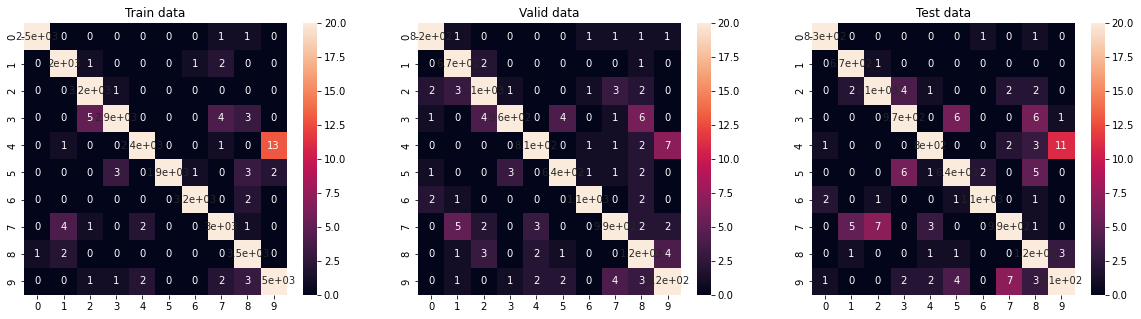

In [145]:
# confusion matrix plot
fig, axes = plt.subplots(1, 3, figsize=(20,5))
sns.heatmap(matric_cnn_clf_best_train, annot=True, vmin=0, vmax=20, ax=axes[0])
axes[0].set_title("Train data")
sns.heatmap(matric_cnn_clf_best_valid, annot=True, vmin=0, vmax=20, ax=axes[1])
axes[1].set_title("Valid data")
sns.heatmap(matric_cnn_clf_best_test, annot=True, vmin=0, vmax=20, ax=axes[2])
axes[2].set_title("Test data")

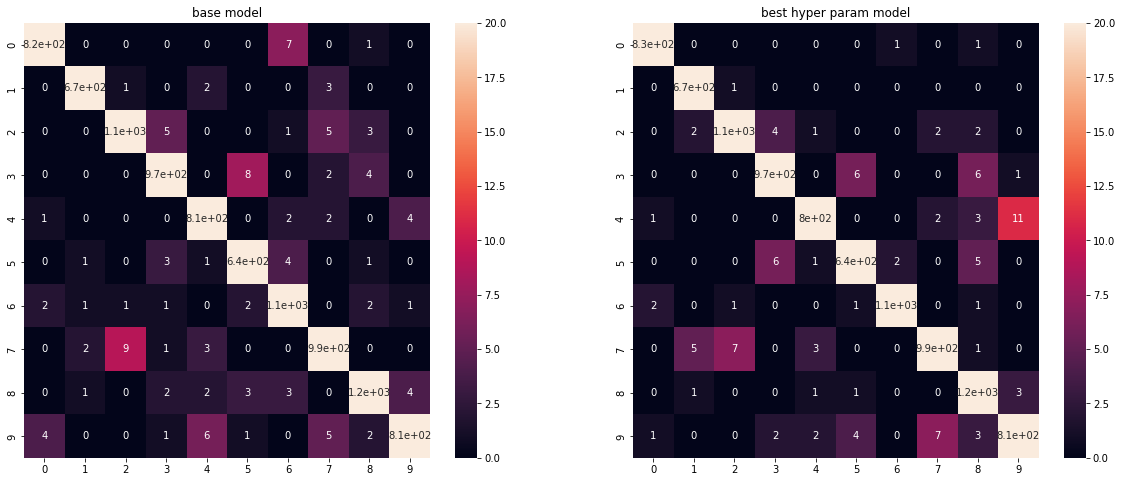

In [146]:
# compare confusion matrix between best hyper param model and base model in test data
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

map_min, map_max = 0, 20
sns.heatmap(matric_cnn_clf_base_test, annot=True, vmin=map_min, vmax=map_max, ax=axs[0])
sns.heatmap(matric_cnn_clf_best_test, annot=True, vmin=map_min, vmax=map_max, ax=axs[1])
axs[0].set_title("base model")
axs[1].set_title("best hyper param model")
plt.show()

#### observation

model(best param) prediction is better than base model without (label:4, prediction:9)

### 3-2-3.observe wrong prediction of valid data

In [150]:
wrong_predict_mask = (y_valid != y_pred_valid_best)

In [151]:
wrong_predict_indicies = np.where(wrong_predict_mask == True)[0]

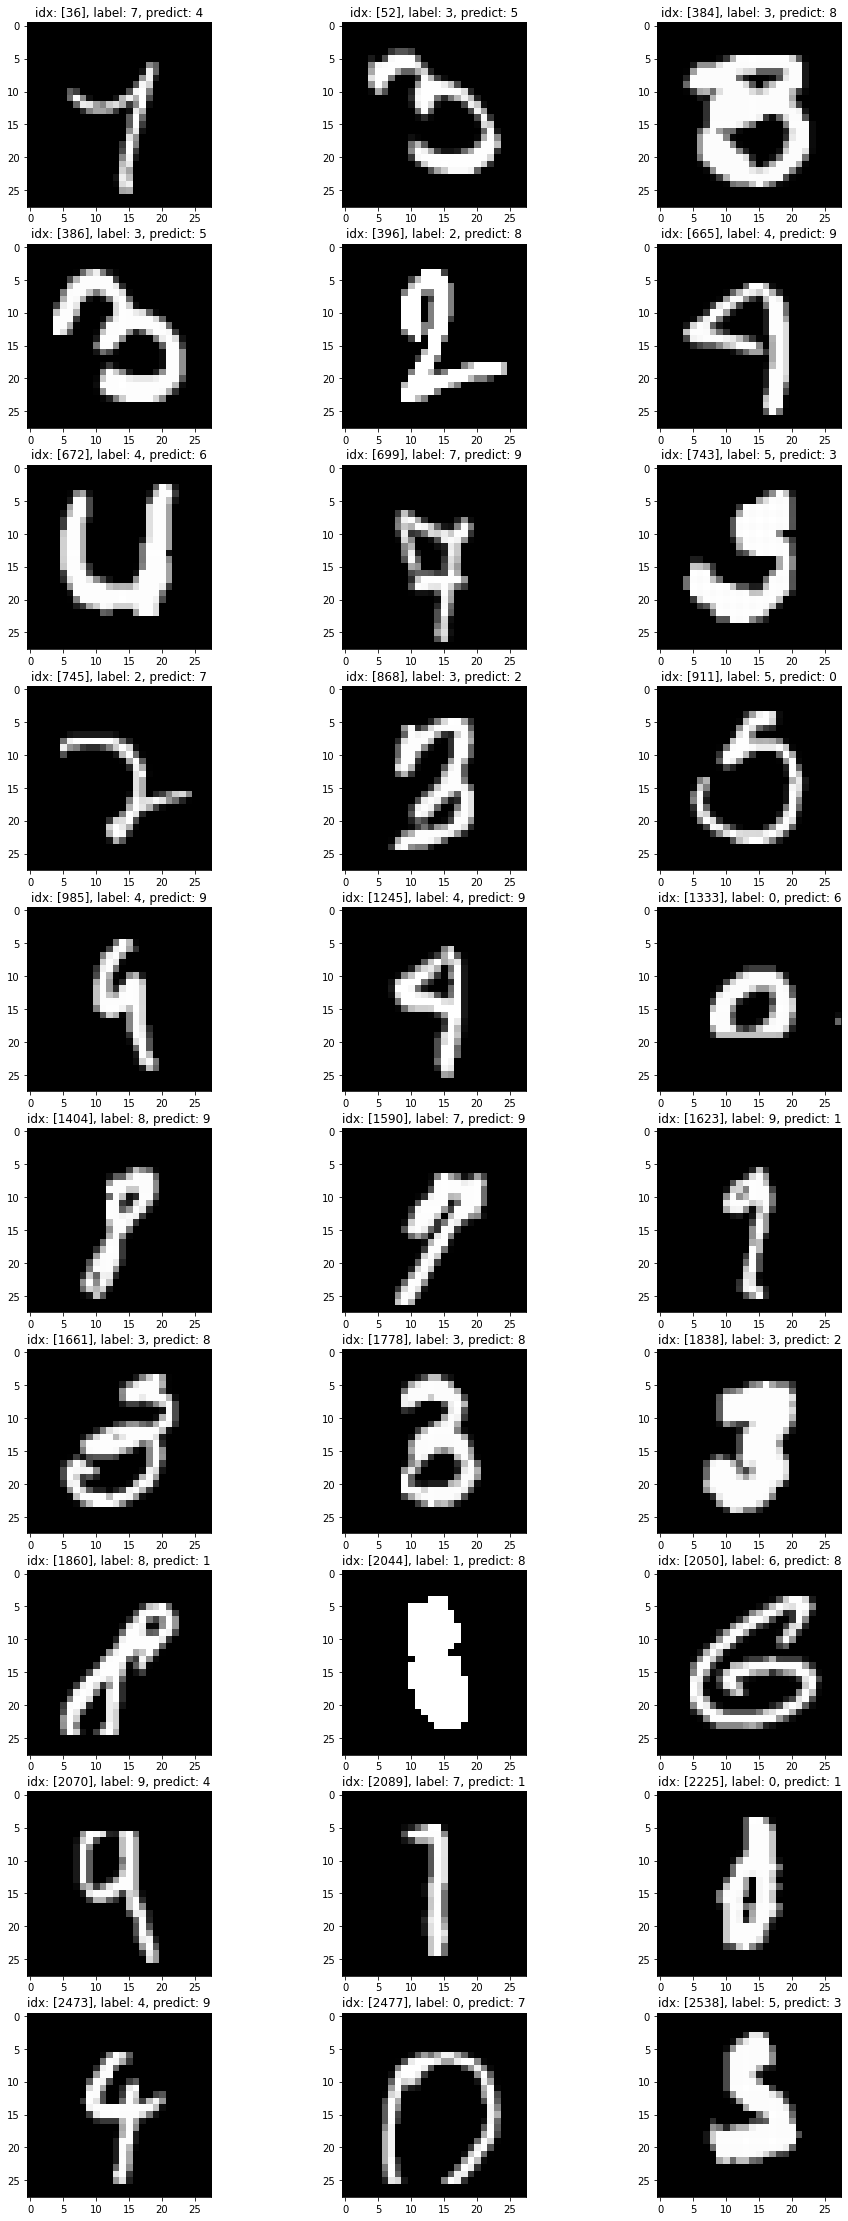

In [152]:
plt.subplots(10, 3, figsize=(16, 40))
plt.subplot(10,3,1)

for count, wrong_idx in enumerate(wrong_predict_indicies):
    if count >= 30:
        break
    plt.subplot(10, 3, count + 1)
    plt.imshow(X_valid_scaled[wrong_idx].reshape(28, 28), cmap="gray")
    plt.title("idx: [{}], label: {}, predict: {}".format(wrong_idx, y_valid[wrong_idx], y_pred_valid_best[wrong_idx]))